In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import image
import os

In [2]:
#loading 240 images for training & 160 for testing

train_image_list=[]
test_image_list=[]
for i in range(1,41):
    j=1
    s = os.listdir('s'+str(i)+'/')
    for image in s:
        if(j<=6):
            im = Image.open('s'+str(i)+'/' + image)
            train_image_list.append(np.asarray(im).flatten())
        else:
            im = Image.open('s'+str(i)+'/' + image)
            test_image_list.append(np.asarray(im).flatten())
        j+=1


In [3]:
print(len(train_image_list))
print(len(test_image_list))

240
160


## Training 

In [4]:
# 1. Generating the face dataset for training (60%)

#Face_Db = image_list[:,0:6]
Face_Db = np.array(train_image_list).T
print(Face_Db.shape)

(10304, 240)


In [5]:
# 2. Mean Calculation

mn,p = Face_Db.shape
M = np.zeros((mn,1))
for i in range(mn):
        for j in range(p):
            M[i] += Face_Db[i][j]
        M[i] /= p
print(M.shape)

(10304, 1)


In [6]:
# 3. Do mean Zero

delt = np.zeros((mn,p))
for i in range(mn):
    for j in range(p):
        delt[i][j]=Face_Db[i][j]-M[i]

In [7]:
# 4. Covariance of delt (mean aligned faces)

def cov(delt):
    row,col=delt.shape
    covm = np.zeros((col,col))        
    for z in range(col):
        for y in range(col):
            covm[z][y] = (1/row) * np.dot(delt[:,y].T,delt[:,z])                   
    return covm


In [8]:
cov_matrix = cov(delt)
print(cov_matrix.shape)

(240, 240)


In [9]:
# 5. eigenvalue and eigenvector decomposition (sorted)

eigenValues, eigenVectors = np.linalg.eig(cov_matrix)
idx = eigenValues.argsort()[::-1]   
eigen_val = eigenValues[idx]
eigen_vector = eigenVectors[:,idx]
eigen_val = np.diag(eigen_val)
print("...Eigen Values...")
print(eigen_val.shape)
print()
print("...Eigen Vector...")
print(eigen_vector.shape)

...Eigen Values...
(240, 240)

...Eigen Vector...
(240, 240)


In [10]:
# 6. Finding the best direction (Generation of feature vectors)

k=100
Feature_vector = eigen_vector[:,0:k]
print(Feature_vector.shape)

(240, 100)


In [11]:
# 7. Generating Eigenfaces

Eigen_faces = np.dot(Feature_vector.T,delt.T)
print(Eigen_faces.shape)

(100, 10304)


In [12]:
# 8. Generating Signature of Each Face

Signature = np.dot(Eigen_faces,delt)
print(Signature.shape)

(100, 240)


## Testing

In [13]:
# 1. Making image list as a column vector

Test_Face_Db = np.array(test_image_list).T
print(Test_Face_Db.shape)

(10304, 160)


In [14]:
# 2. Do mean Zero

Mean_zero=np.zeros((Test_Face_Db.shape))
mn,q = Test_Face_Db.shape
for i in range(mn):
    for j in range(q):
        Mean_zero[i][j] = Test_Face_Db[i][j] - M[i]
        
print(Mean_zero.shape)

(10304, 160)


In [15]:
# 3. Projected test face (signature)

project = np.dot(Eigen_faces,Mean_zero)
print(project.shape)

(100, 160)


In [16]:
# 4. Euclidean distance between projected test face & signature of each face

def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist

In [17]:
def accuracy_fun(true_cl,pred_cl):
    count = 0
    for i in range(len(true_cl)):
        if(true_cl[i] == pred_cl[i]):
            count += 1
    accuracy_val = (count/len(true_cl))*100
    return accuracy_val

In [19]:
# column wise minimum distance calculation

import sys

true_Labels = np.arange(0,160)
true_Labels = (true_Labels//4)
accuracy_curve = []
for k in range(0,31):

    min_dist = sys.maxsize
    distances = [0] * Test_Face_Db.shape[1]
    classes = [0] * Test_Face_Db.shape[1]

    for i in range (Test_Face_Db.shape[1]):
        for j in range (Face_Db.shape[1]):
            dist = euclidean_dist(project[0:k,i],Signature[0:k,j])
            if(dist < min_dist):
                min_dist = dist
                label = j

        distances[i] = min_dist
        classes[i] = (label//6)
        min_dist = sys.maxsize

    accuracy = accuracy_fun(true_Labels,classes)
    accuracy_curve.append(accuracy)

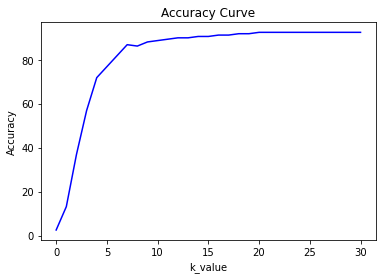

In [22]:
plt.plot(np.arange(0,31), accuracy_curve, color ="blue")  
plt.title("Accuracy Curve")  
plt.xlabel("k_value")  
plt.ylabel("Accuracy") 
plt.show()